<a href="https://colab.research.google.com/github/madhes23/deep_learning/blob/optimization/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from enum import Enum
import copy

# Importing and plotting samples

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

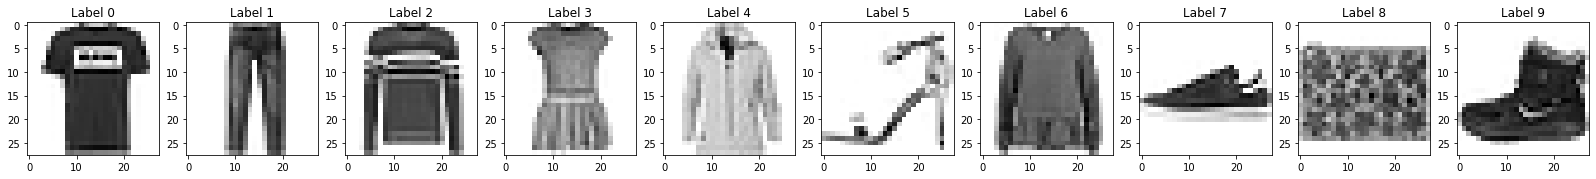

In [ ]:
no_of_items = 10

fig, axes = plt.subplots(nrows = 1, ncols=10, figsize = (28, 28))
for item in range(no_of_items):
  index = 0
  while(y_train[index] != item): #searching for the first occurance of the element
    index = index+1
  
  ax = axes[item]
  ax.imshow(x_train[index], cmap='gray_r')
  ax.set_title('Label {}'.format(item))

# Reshaping the data for nerual network


In [ ]:
no_of_pixels = x_train[0].size
x_train = x_train.reshape(-1, no_of_pixels)/255
x_test = x_test.reshape(-1, no_of_pixels)/255

# Some Utility functions

In [ ]:
class ActivationFunction(Enum):
  SIGMOID = 1
  RELU = 2
  TAN_H = 3

class InitializationMethod(Enum):
  UNIFORM_RANDOM = 1
  UNIFORM_XAVIER = 2
  GAUSSIAN_XAVIER = 3

class OutputFunction(Enum):
  SOFTMAX = 1
  SQUARE_ERROR = 2

class Algorithm(Enum):
  GD = 1
  SGD = 2
  MOMENTUM_GD = 3

class ErrorCalculationMethod(Enum):
  CROSS_ENTROPY = 1
  MEAN_SQUARE_ERROR = 2

def calc_accuracy(predicted, expected):
  return np.sum(predicted == expected) / expected.size

# Forward Propogation

In [ ]:
class Classification:
  no_of_class = None
  hidden_layer = None
  input_layer = None
  activation_func = None
  output_func = None
  initialization_method = None
  error_calculation = None
  max_epoch = None
  learning_rate = None
  weight = []
  bias = []
  def __init__(self, _no_of_class, _hidden_layer, _input_layer, _max_epoch, _activation_fun=ActivationFunction.RELU, _initialization_method=InitializationMethod.UNIFORM_XAVIER, _output_function = OutputFunction.SOFTMAX, _error_calculation=ErrorCalculationMethod.CROSS_ENTROPY, _learning_rate = 0.01) -> None:
    self.no_of_class = _no_of_class
    self.hidden_layer = _hidden_layer
    self.activation_func = _activation_fun
    self.max_epoch = _max_epoch
    self.input_layer = _input_layer
    self.output_func = _output_function
    self.learning_rate = _learning_rate
    self.initialization_method = _initialization_method
    self.error_calculation = _error_calculation


  def set_weight_and_bias(self):
    #appending all these in a single list (easy for initializing w and b)
    layer = [self.input_layer]
    layer = layer + self.hidden_layer
    layer.append(self.no_of_class)

    #going to use 1-based indexing (as tought in the class)
    #so adding some random matrix in 0-th index
    w = [np.random.rand(1,1)]
    b = [np.random.rand(1,1)]
    if(self.initialization_method == InitializationMethod.UNIFORM_RANDOM): 
      low = -1
      high = 1
      i = 1
      while i < len(layer):
        w.append(np.random.uniform(low, high, size=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))
        i +=1
    
    if(self.initialization_method == InitializationMethod.UNIFORM_XAVIER): 
      for i in range(1, len(layer)):
        inputs = layer[i-1]
        outputs = layer[i]
        # x = math.sqrt(6/ inputs+outputs)
        x = math.sqrt(1/inputs)
        w.append(np.random.uniform(low=-x, high=x, size=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))

    if(self.initialization_method == InitializationMethod.GAUSSIAN_XAVIER): 
      mu = 0.0
      for i in range(1, len(layer)):
        inputs = layer[i-1]
        outputs = layer[i]
        # sigma = math.sqrt(6 / inputs+outputs)
        sigma = math.sqrt(1/ inputs)
        w.append(np.random.normal(mu, sigma, size=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))

    return w, b


  def activation_function(self, a):
    if(self.activation_func == ActivationFunction.SIGMOID):   
      clipping_limit = 400
      return 1.0 / (1.0 + np.exp(-np.clip(a,-clipping_limit,clipping_limit)))


  def df_activation_function(self, a):
    if(self.activation_func == ActivationFunction.SIGMOID): #sigmoid
      return self.activation_function(a) * (1 - self.activation_function(a))


  def output_function(self, a):
    if(self.output_func == OutputFunction.SOFTMAX): 
      a = a - np.max(a)
      return np.exp(a) / np.sum(np.exp(a), axis=1, keepdims=True)


  def calc_error(self, predicted_distribution, true_label):
    if(self.error_calculation == ErrorCalculationMethod.CROSS_ENTROPY):
      rows = np.arange(true_label.shape[0]) #setting row number from 0 to length(true label)
      cols = true_label
      return sum(-np.log(predicted_distribution[rows,cols])) / true_label.shape[0] #NOTE: If the predicted value is 0, -log wil give inf


  def forward_propogation(self, input):
    #for using 1 based indexing, adding some random matrix in 0-th index
    a = [np.random.rand(1,1)]
    h = [input]

    a.append(self.bias[1] + np.dot(input, self.weight[1].T))
    
    for i in range(1, len(self.hidden_layer)+1):
      h.append(self.activation_function(a[i])) #calculating h[i]
      a.append(self.bias[i+1] + np.dot(h[i], self.weight[i+1].T)) #calculating a[i+1]
    h.append(self.output_function(a[-1]))
    return a, h


  def backward_propogation(self, a, h, true_label):
    number_of_layers = len(a)-1 #including the output layer, excluding input layer ('L' value used in the lectures)
    del_a = [None] * (number_of_layers+1)
    del_h = [None] * (number_of_layers+1)
    del_w = [None] * (number_of_layers+1)
    del_b = [None] * (number_of_layers+1)
    
    #computing del_a_L
    del_a[-1] = h[-1].copy()
    row_ind = np.arange(true_label.shape[0]) #creating numbers 0 to batch size (for row indices)
    del_a[-1][row_ind,true_label] -= 1

    for k in range(number_of_layers, 0, -1):
      #computing gradients w.r.t parameters
      del_w[k] = np.dot(del_a[k].T, h[k-1])
      del_b[k] = np.sum(del_a[k], axis=0)

      #computing gradients w.r.t layer below (post-activation)
      del_h[k-1] = np.dot(a[k], self.weight[k])

      #computing gradients w.r.t layer below (pre-activation)
      del_a[k-1] = del_h[k-1] * self.df_activation_function(a[k-1])
    
    #setting the 0-th index to some random array of (1,1)
    #so that it won't cause dimention mismatch
    del_w[0] = np.random.rand(1,1)
    del_b[0] = np.random.rand(1,1)
    return np.array(del_w, dtype=object), np.array(del_b, dtype=object)


  def fit(self, x_train, y_train): 
    for i in range(self.max_epoch):
      tot_del_w = np.array([], dtype=object) #creating empty arrays
      tot_del_b = np.array([], dtype=object)
      a, h = self.forward_propogation(x_train)
      del_w, del_b = self.backward_propogation(a, h, y_train)

      # if(tot_del_w.size == 0): 
      #   tot_del_w = del_w
      #   tot_del_b = del_b

      # else:
      #   tot_del_w += del_w
      #   tot_del_b += del_b

      tot_del_w /= len(x_train)
      tot_del_b /= len(x_train)
      # if (i>=50 and i<55):
      #   print("PRINTING W AND B VALUE AT {} TH EPOCH".format(i))
      #   print("w: ", self.weight)
      #   print("b: ", self.bias)
      self.weight -= self.learning_rate * del_w
      self.bias -= self.learning_rate * del_b
      err = self.calc_error(h[-1], y_train)
      print("Completed epoch : {} \t Error: {}".format(i, err))


  def test(self, x_test, y_test):
    print("x_test {} \t y_test {}".format(x_test.shape, y_test.shape))
    _ , h = self.forward_propogation(x_test)
    predicted_distribution = h[-1]
    return calc_accuracy(np.argmax(predicted_distribution, axis=1), y_test)


In [125]:
model = Classification(_no_of_class=10, 
                       _hidden_layer=[64, 64], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _max_epoch=2000)
model.weight, model.bias = model.set_weight_and_bias()

model.fit(x_train[:1000], y_train[:1000])
# model.test(x_test[:50], y_test[:50])

<ipython-input-123-ad3899e8a2c0>:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weight -= self.learning_rate * tot_del_w
<ipython-input-123-ad3899e8a2c0>:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.bias -= self.learning_rate * tot_del_b


Completed epoch : 0 	 Error: 2.365284057966437
Completed epoch : 1 	 Error: 2.362669688865415
Completed epoch : 2 	 Error: 2.3601892977900647
Completed epoch : 3 	 Error: 2.357833515502964
Completed epoch : 4 	 Error: 2.3555936872831507
Completed epoch : 5 	 Error: 2.3534618251847244
Completed epoch : 6 	 Error: 2.351430580562205
Completed epoch : 7 	 Error: 2.34949322074458
Completed epoch : 8 	 Error: 2.347643600045415
Completed epoch : 9 	 Error: 2.345876122498797
Completed epoch : 10 	 Error: 2.344185698086166
Completed epoch : 11 	 Error: 2.3425676957494215
Completed epoch : 12 	 Error: 2.3410178963176262
Completed epoch : 13 	 Error: 2.3395324476340535
Completed epoch : 14 	 Error: 2.3381078232529986
Completed epoch : 15 	 Error: 2.336740785333181
Completed epoch : 16 	 Error: 2.335428351841656
Completed epoch : 17 	 Error: 2.33416776787099
Completed epoch : 18 	 Error: 2.3329564807094427
Completed epoch : 19 	 Error: 2.331792118239154
Completed epoch : 20 	 Error: 2.330672470231

KeyboardInterrupt: ignored